# Plot Debugging

I am noticing some wierd things in the plots, and I am going to attempt to fix them on this branch:
- #41, it seems like the ball and the players are on different time scales?
- #14, the event only shows up for one frame
- #17, the players in the wrong spots!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os

# Matt written files
from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
# pandas options
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

Example plays are 
- 326 -- fixed!
- 18 -- fixed!

- 124 -- fixed!
- 203 -- fixed!

Distance between ball and player is large on average, should maybe clean up 12.199183415462679


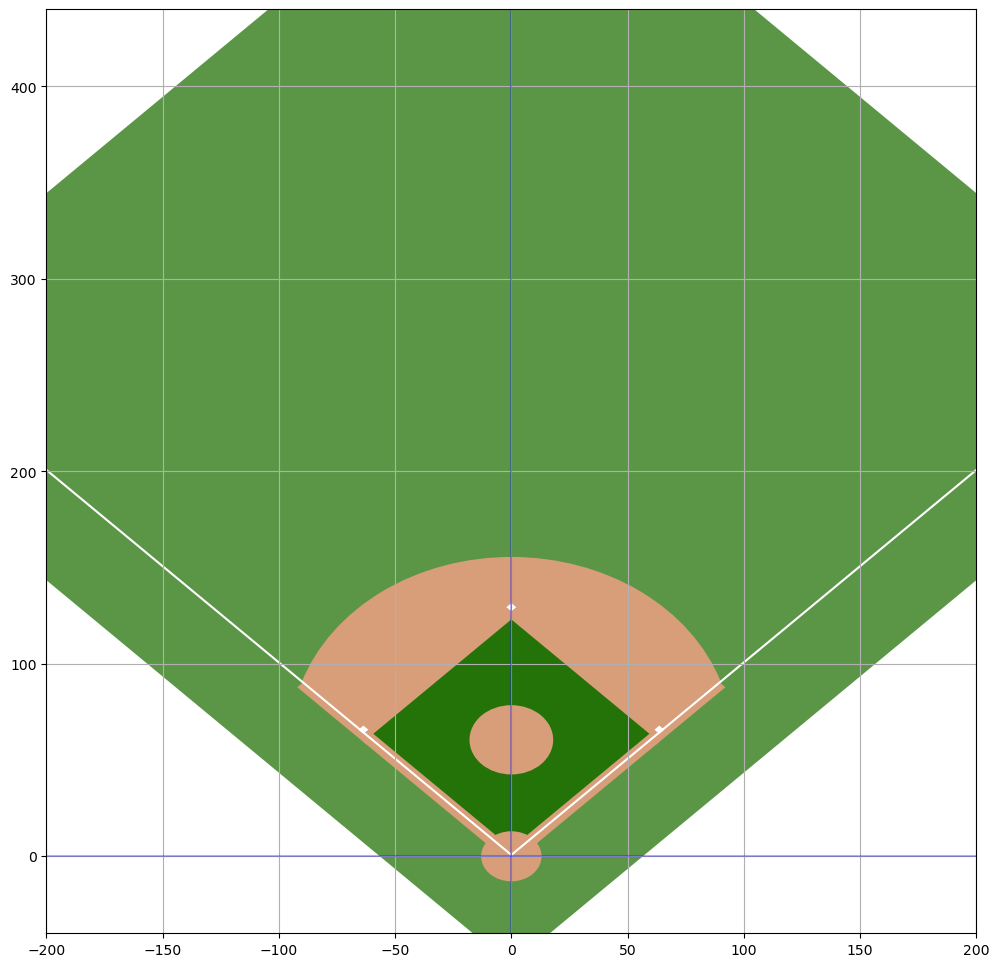

In [3]:
bf_1903_01 = Baseball_Field("1903_01_TeamNE_TeamA2")

In [4]:
bf_1903_01.clear_plot()

play_id = 203

# bf_1903_01.plot_all_components(play_id=play_id)
# bf_1903_01.fig

bf_1903_01.create_gif(play_id=play_id, tag="--new ts")

MovieWriter ffmpeg unavailable; using Pillow instead.


In [ ]:
game_events_1903_01 = bf_1903_01.game_obj.game_events_df.copy()
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()
player_pos_1903_01 = bf_1903_01.game_obj.new_player_pos.copy()
ball_pos_1903_01 = bf_1903_01.game_obj.ball_pos_df.copy()



game_events_1903_01.head(2)

In [ ]:
game_events_1903_01[game_events_1903_01["play_id"] == 124]

In [ ]:
ball_pos_1903_01.loc[(ball_pos_1903_01["play_id"] == 326)
                       , :]

In [ ]:
player_pos_1903_01.loc[(player_pos_1903_01["play_id"] == 124) &
                       (player_pos_1903_01["player_position"] == 3), :]

In [ ]:
game_events_1903_01.loc[(game_events_1903_01["play_id"] == 326) &
                        (game_events_1903_01["event"].isin(["ball acquired", "throw (ball-in-play)"])), ]

In [ ]:
## stretch the ball pos to the player pos

# trust the ball pos at ball acquired

# trust which time scale? I think the ball probably
play_id = 326

ball_acq = game_events_1903_01.loc[
    (game_events_1903_01["play_id"] == play_id) &
    (game_events_1903_01["event"] == "ball acquired")
    , "timestamp"
].values[0]


this_play_ball = ball_pos_1903_01.loc[ball_pos_1903_01["play_id"] == play_id]
this_play_ball["this_play_ms"] = this_play_ball.timestamp - this_play_ball.timestamp.min()


first_ball_acq_x = ball_pos_1903_01.loc[ball_pos_1903_01["timestamp"] == ball_acq, "ball_position_x"]


this_play_players = player_pos_1903_01.loc[
    (player_pos_1903_01["play_id"] == play_id) &
    (player_pos_1903_01["player_position"] == 5)
    , :]

this_play_players["this_play_ms"] = this_play_players.timestamp - this_play_players.timestamp.min()


overlap_ms_players = this_play_players.loc[
    (abs(this_play_players["field_x"] - first_ball_acq_x.values[0]) < 1)
    , "this_play_ms"].values[0]


overlap_ms_ball = this_play_ball.loc[this_play_ball["timestamp"] == ball_acq, "this_play_ms"].values[0]


time_delta = overlap_ms_players - overlap_ms_ball

In [ ]:
time_delta

In [ ]:
f, ax = plt.subplots()



ax.plot(this_play_players["this_play_ms"], this_play_players["field_x"], color = "orange", label="player") 
ax.plot(this_play_ball["this_play_ms"]+time_delta, this_play_ball["ball_position_x"], color = "blue", label="ball") 

ax.legend()

In [ ]:
this_play_players.timestamp.min() - this_play_ball.timestamp.min()

### Do the above procedure for every play!

In [ ]:
def line_up_ball_and_players(game_events, player_pos, ball_pos, margin=3):
        """
        There are many instances where it seems like the ball and player are lagged in someway
        
        Make a function to line up timestamps based on the distance the ball is from the player 
        that acquired the ball when it is marked as acquired
        
        
        margin (int or float) defaults to 3
             how far we allow the ball to be away from the player and still say acquired in feet
             3 is roughly an arms length, could do better with limb data
        
        """
        
        game_events = game_events.copy()
        player_pos = player_pos.copy()
        ball_pos = ball_pos.copy()
        
        # get all of the players and times when the ball was acquired
        ball_acq_event = game_events.loc[
            game_events["event"] == "ball acquired"
        ][["play_id", "player_position", "timestamp"]]
        
        # get ball_position of all the ball acq for each play
        ball_acq_pos = ball_pos.merge(
            ball_acq_event, 
            how="inner", 
            on=["play_id", "timestamp"]
        )[["play_id", "ball_position_x", "ball_position_y"]]
        
        # get the player_pos for each player that first acquires the ball for each play
        player_pos_acq = player_pos.merge(
            ball_acq_event, 
            how="inner", 
            on=["play_id", "player_position"], 
            suffixes=["", "_ball_acq"]
        )
        
        # merge the ball pos when first acquired and player dfs
        combined_acq = player_pos_acq.merge(ball_acq_pos, on="play_id", how="left")

        # get the distance between the ball and player who acquired
        combined_acq["delta_dist"] = np.sqrt(
            (combined_acq["field_x"] - combined_acq["ball_position_x"])**2 +\
            (combined_acq["field_y"] - combined_acq["ball_position_y"])**2                                    
        )

        # I think the raw min won't work because you could reach for the ball and 
        # then run over to where you picked it so have a margin and pick the first
        # time you get close enough
        when_within_margin = combined_acq[
            combined_acq["delta_dist"] < margin
        ].groupby(["play_id", "player_position"]).min("delta_dist")
        
        when_within_margin["time_offset"] = (when_within_margin["timestamp"] - when_within_margin["timestamp_ball_acq"])
        
        # self.ts_lag_df = when_within_margin
        # this step picks corrects for the case where the first acquiring player
        # doesn't have to move (and thus is already in the correct spot too early)
        when_within_margin =  when_within_margin.loc[
            when_within_margin.groupby("play_id")["time_offset"].idxmax()
        ]

            
        plays_within_margin = when_within_margin.reset_index()["play_id"].unique()

        # pick a looser margin for the other ones that don't work
        # so we at least have coverage
        plays_that_not_within_margin = set(combined_acq["play_id"].unique()) - \
            set(plays_within_margin)

        not_within_margin = combined_acq.loc[
            (combined_acq["play_id"].isin(plays_that_not_within_margin)) &
            (combined_acq["delta_dist"] < (2 * margin))
        ].groupby(["play_id", "player_position"]).min()
        
        not_within_margin["time_offset"] = (not_within_margin["timestamp"] - not_within_margin["timestamp_ball_acq"])

        
        not_within_margin =  not_within_margin.loc[
            not_within_margin.groupby("play_id")["time_offset"].idxmax()
        ]
        
        # not_within_margin = not_within_margin.reset_index().groupby("play_id", as_index=False)[].max()
        
        all_plays = pd.concat([not_within_margin, when_within_margin]).sort_values("play_id")

        # return all_plays
        
        
            
        # compute the lags needed for each play to line up the ball with the player + margin ft
        # all_plays["time_offset"] = all_plays.apply(lambda row: row["timestamp"] - row["timestamp_ball_acq"], axis=1)
        ts_lag_df = all_plays.reset_index()[["play_id", "time_offset"]]
                
        # self.ts_lag_df = ts_lag_df
        #return ts_lag_df

        
        player_pos["old_ts"] = player_pos["timestamp"]

        # which TS to anchor to? ball makes the gif work, but ruins the events on screen
        # its minus if merging with player pos, addition if ball
        
        # merge only the positive, because the others are probs 
        # just the ball getting to the front of someone
        new_player_pos = player_pos.merge(ts_lag_df[ts_lag_df > 0], 
                               how = "left", 
                               left_on="play_id",
                               right_on="play_id"
        )

        

        
        new_player_pos["timestamp"] = new_player_pos.apply(
            lambda row:                                           
            row["old_ts"] - (row["time_offset"] if pd.notnull(row["time_offset"]) else 0),
            axis=1
        )

        return new_player_pos

In [ ]:
game_events_1903_01 = bf_1903_01.game_obj.game_events_df.copy()
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()
player_pos_1903_01 = bf_1903_01.game_obj.player_pos_df.copy()
ball_pos_1903_01 = bf_1903_01.game_obj.ball_pos_df.copy()

In [ ]:
test = line_up_ball_and_players(game_events_1903_01, player_pos_1903_01, ball_pos_1903_01, margin=3)
test

#test[test["play_id"] == 124]

In [ ]:
test.time_offset.describe()

In [ ]:
test[test["play_id"] == 124]

In [ ]:
# get the player and time that the ball was first acquired
ball_acq_event = game_events_1903_01.loc[
    game_events_1903_01["event"] == "ball acquired"
][["play_id", "player_position", "timestamp"]]

# ideally want to pick the offset that mins all of these critical points when a ball was acquired,
# because thats where we know the ball and players should be in the same spot!
ball_acq_event["play_id"].value_counts()[:10]

In [ ]:
# get ball_position of the first ball acq for each play
ball_acq_pos = ball_pos_1903_01.merge(
    ball_acq_event, 
    how="inner", 
    on=["play_id", "timestamp"]
)[["play_id", "ball_position_x", "ball_position_y"]]

ball_acq_pos

In [ ]:
# get the player_pos for each player that first acquires the ball for each play
player_pos_acq = player_pos_1903_01.merge(
    ball_acq_event, 
    how="inner", 
    on=["play_id", "player_position"], 
    suffixes=["", "_ball_acq"]
)

player_pos_acq[player_pos_acq["play_id"] == 124]

In [ ]:
# dist margin, how far we allow the play to be off
# 3 is roughly an arms length, could do better with limb data
margin = 3

# merge the ball pos when first acquired and player dfs
combined_first_acq = player_pos_acq.merge(ball_acq_pos, on="play_id", how="left")

combined_first_acq

In [ ]:
# the df above has a row for every frame, for ever ball acquired event -- 
# e.g. if there was a turned DP should have 3 ball acqs
# the min for each player will be valid candidates, but we should pick the max of those!

In [ ]:
# get the distance between the ball and player who acquired
combined_first_acq["delta_dist"] = np.sqrt(
    (combined_first_acq["field_x"] - combined_first_acq["ball_position_x"])**2 +\
    (combined_first_acq["field_y"] - combined_first_acq["ball_position_y"])**2                                    
)

# could totally do a more complex min here, e.g. with fill x and y
# I think the raw min won't work, so have a margin
# and pick the first time this happens
when_within_margin = combined_first_acq[combined_first_acq["delta_dist"] < margin].groupby(["play_id", "player_position"]).min("delta_dist")

when_within_margin["time_delta"] = (when_within_margin["timestamp"] - when_within_margin["timestamp_ball_acq"])

# when_within_margin.loc[124, :].max()


# I think do the max of these!
when_within_margin = when_within_margin.reset_index().groupby("play_id", as_index=False).max("time_delta")


In [ ]:
when_within_margin[when_within_margin["play_id"] == 124]

In [ ]:
# pick a looser margin for the other ones that don't work
# so we at least have coverage

plays_within_margin = when_within_margin.reset_index()["play_id"].unique()

plays_that_not_within_margin = set(combined_first_acq["play_id"].unique()) - set(plays_within_margin)

not_within_margin = combined_first_acq.loc[
    (combined_first_acq["play_id"].isin(plays_that_not_within_margin)) &
    (combined_first_acq["delta_dist"] < 2*margin)
].groupby(["play_id", "player_position"]).min()


not_within_margin = not_within_margin.reset_index().groupby("play_id", as_index=False).max("time_delta")

In [ ]:
not_within_margin

In [ ]:

all_plays = pd.concat([not_within_margin, when_within_margin]).sort_values("play_id")

# compute the lags needed for each play to line up the ball with the player + 3 ft
ts_lag_df = (all_plays["timestamp"] - all_plays["timestamp_ball_acq"])
ts_lag_df.name = "time_offset"

In [ ]:
all_plays["time_offset"] = all_plays.apply(lambda row: row["timestamp"] - row["timestamp_ball_acq"], axis=1)

ts_lag_df = all_plays[["play_id", "time_offset"]]

In [ ]:
ts_lag_df.describe()

In [ ]:
ts_lag_df[]

In [ ]:
# do the computing of new timestamps for ball

ball_pos_1903_01["old_ts"] = ball_pos_1903_01["timestamp"]


# merge only the positive, because the others are probs 
# just the ball getting to the front of someone
new_ball_pos_1903_01 = ball_pos_1903_01.merge(ts_lag_df[ts_lag_df > 0], 
                       how = "left", 
                       left_on="play_id",
                       right_on="play_id"
)


new_ball_pos_1903_01["timestamp"] = new_ball_pos_1903_01.apply(
    lambda row:                                           
    row["old_ts"] + (row["time_offset"] if pd.notnull(row["time_offset"]) else 0),
    axis=1
)


In [ ]:
new_ball_pos_1903_01.loc[new_ball_pos_1903_01["timestamp"] != new_ball_pos_1903_01["old_ts"], "play_id"].unique()

In [ ]:
np.isnan()

### verify that this works before adding this into Game

In [ ]:
plt.close()

play_id = 124#325

this_play_ball = ball_pos_1903_01.loc[ball_pos_1903_01["play_id"] == play_id]

player = 4# ball_acq_event.loc[play_id, "player_position"]

this_play_players = test.loc[
    (test["play_id"] == play_id) &
    (test["player_position"] == player)
    , :]

f, ax = plt.subplots()

ax.plot(this_play_players["timestamp"], this_play_players["field_x"], color = "orange", label="player") 
ax.plot(this_play_ball["timestamp"], this_play_ball["ball_position_x"], linestyle="dotted", color = "blue", label="ball_without_lag") 


offset = 0 # ts_lag_df[play_id]

ax.plot(this_play_ball["timestamp"] + offset, this_play_ball["ball_position_x"], color = "blue", label="ball") 

ax.set_title("Lag of {}".format(offset))

ax.legend()

plt.show()

### Things that need to happen to merge this with Game

- add the procedure I just made
- use that to reset the timestamps for ball
    - map the old ts to a variable called "old_ts"
- Recompute the ball preprocessing stuff, or just order it so it doesn't happed the first time?


Not as critical, but could be a helper:
- add a "this_play_ts" in player_pos and ball_pos

```python
# get the timestamps of the play where 0 is the start of the play
ball_pos_1903_01 = ball_pos_1903_01.merge(ball_pos_1903_01.groupby("play_id")["timestamp"].min(), on="play_id", suffixes=["", "_play_min"])
ball_pos_1903_01["this_play_ts"] = ball_pos_1903_01["timestamp"] - ball_pos_1903_01["timestamp_play_min"]
```



### I THINK IT IS JUST A CONSTANT FACTOR PER GAME?
- It seems like most games this is not a problem from looking at some gifs?

### Double check whether it is a constant factor per game by running this

In [ ]:
bf_09 = Baseball_Field("1903_09_TeamNJ_TeamB")

In [ ]:
game_events_09 = bf_09.game_obj.game_events_df.copy()
game_info_09 = bf_09.game_obj.game_info_df.copy()
player_pos_09 = bf_09.game_obj.new_player_pos.copy()
ball_pos_09 = bf_09.game_obj.ball_pos_df.copy()


In [ ]:
game_events_09[game_events_09["event"] == "throw (ball-in-play)"].head(3)

In [ ]:
bf_09.clear_plot()

play_id = 24

# bf_09.plot_all_components(play_id=play_id)
# bf_09.fig

# bf_09.create_gif(play_id=play_id, tag="--debugging, markers are off")

In [ ]:
## stretch the ball pos to the player pos

# trust the ball pos at ball acquired

# trust which time scale? I think the ball probably
play_id = 15

ball_acq = game_events_09.loc[
    (game_events_09["play_id"] == play_id) &
    (game_events_09["event"] == "ball acquired")
    , "timestamp"
].values[0]


this_play_ball = ball_pos_09.loc[ball_pos_09["play_id"] == play_id]
this_play_ball["this_play_ms"] = this_play_ball.timestamp - this_play_ball.timestamp.min()


first_ball_acq_x = ball_pos_09.loc[ball_pos_09["timestamp"] == ball_acq, "ball_position_x"]


this_play_players = player_pos_09.loc[
    (player_pos_09["play_id"] == play_id) &
    (player_pos_09["player_position"] == 6)
    , :]

this_play_players["this_play_ms"] = this_play_players.timestamp - this_play_players.timestamp.min()


overlap_ms_players = this_play_players.loc[
    (abs(this_play_players["field_x"] - first_ball_acq_x.values[0]) < 1)
    , "this_play_ms"].values[0]


overlap_ms_ball = this_play_ball.loc[this_play_ball["timestamp"] == ball_acq, "this_play_ms"].values[0]


time_delta = overlap_ms_players - overlap_ms_ball

In [ ]:
time_delta

In [ ]:
bf_09.clear_plot()
plt.close()

f, ax = plt.subplots()

play_id = 15

thirdbaseman_df = player_pos_09.loc[(player_pos_09["play_id"] == play_id) &
                       (player_pos_09["player_position"] == 6), :]


ball_df = ball_pos_09.loc[(ball_pos_09["play_id"] == play_id)
                       , :]

ax.plot(thirdbaseman_df["timestamp"], thirdbaseman_df["field_x"], color = "orange", label="player") 
ax.plot(ball_df["timestamp"]+3000, ball_df["ball_position_x"], color = "blue", label="ball") 
ax.legend()

f

### The one has a smaller dist Which game: 1900_03_TeamKJ_TeamB

In [ ]:
# Check whether 3000 is still the correct buffer?
bf_03 = Baseball_Field("1903_05_TeamND_TeamA2")

In [ ]:
game_events_03 = bf_03.game_obj.game_events_df.copy()
game_info_03 = bf_03.game_obj.game_info_df.copy()
player_pos_03 = bf_03.game_obj.new_player_pos.copy()
ball_pos_03 = bf_03.game_obj.ball_pos_df.copy()


In [ ]:
game_events_03[game_events_03["event"] == "throw (ball-in-play)"].head(3)

In [ ]:
bf_03.clear_plot()
plt.close()

f, ax = plt.subplots()

play_id = 46

thirdbaseman_df = player_pos_03.loc[(player_pos_03["play_id"] == play_id) &
                       (player_pos_03["player_position"] == 7), :]


ball_df = ball_pos_03.loc[(ball_pos_03["play_id"] == play_id)
                       , :]

ax.plot(thirdbaseman_df["timestamp"], thirdbaseman_df["field_x"], color = "orange", label="player") 
ax.plot(ball_df["timestamp"] +3000, ball_df["ball_position_x"], color = "blue", label="ball") 
ax.legend()

f

In [ ]:
bf_03.clear_plot()

play_id = 46

bf_03.plot_all_components(play_id=play_id)
bf_03.fig

# bf_03.create_gif(play_id=play_id, tag="--debugging, no clue")

## See a play that works, before I go messing with things

1903_23_TeamNA_TeamA1_play148--steal, not picked

In [6]:
bf_23 = Baseball_Field("1903_23_TeamNA_TeamA1")

In [7]:
game_events_23 = bf_23.game_obj.game_events_df.copy()
game_info_23 = bf_23.game_obj.game_info_df.copy()
player_pos_23 = bf_23.game_obj.new_player_pos.copy()
ball_pos_23 = bf_23.game_obj.ball_pos_df.copy()

game_events_23.head(5)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo
1,1903_23_TeamNA_TeamA1,1,1,1,19510,1,1,pitch,2.0,ball acquired,19960.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1903_23_TeamNA_TeamA1,1,1,1,19960,2,2,ball acquired,5.0,end of play,19960.0,1.0,pitch,19510.0,NaN,NaN,NaN
3,1903_23_TeamNA_TeamA1,1,1,1,19960,0,5,end of play,NaN,NaN,NaN,2.0,ball acquired,19960.0,NaN,NaN,NaN
4,1903_23_TeamNA_TeamA1,2,1,2,33410,1,1,pitch,4.0,ball hit into play,33810.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1903_23_TeamNA_TeamA1,2,1,2,33810,10,4,ball hit into play,5.0,end of play,33910.0,1.0,pitch,33410.0,NaN,NaN,NaN


In [ ]:
bf_23.clear_plot()
plt.close()

f, ax = plt.subplots()

play_id = 148

thirdbaseman_df = player_pos_23.loc[(player_pos_23["play_id"] == play_id) &
                       (player_pos_23["player_position"] == 2), :]


ball_df = ball_pos_23.loc[(ball_pos_23["play_id"] == play_id)
                       , :]

ax.plot(thirdbaseman_df["timestamp"], thirdbaseman_df["field_x"], color = "orange", label="player") 
ax.plot(ball_df["timestamp"], ball_df["ball_position_x"], color = "blue", label="ball") 
ax.legend()

f

In [ ]:
plt.close()

In [ ]:
game_events_23[game_events_23["event"] == "throw (ball-in-play)"]

In [ ]:
## make some gifs to see if I need to time correct?

bf_23.clear_plot()

play_id = 196

# bf_23.plot_all_components(play_id=play_id)
# bf_23.fig

# bf_23.create_gif(play_id=play_id, tag="--debugging")

## See how many I would like to line up
to see if it is worth writing that function to line things up
- there are 7 of the games that aren't erroring, so I think I should do this

In [ ]:
all_games = get_all_game_strs()

In [ ]:
for which_game in all_games:
    if which_game in ["1902_19_TeamME_TeamA2", "1902_13_TeamMD_TeamA2", "1902_03_TeamMG_TeamA3", "1901_13_TeamLL_TeamB",
                     "1902_18_TeamMB_TeamA1", "1900_02_TeamKJ_TeamB", "1901_06_TeamLI_TeamA3", "1902_27_TeamMH_TeamA3",
                     "1902_13_TeamMK_TeamB", "1903_27_TeamNH_TeamA3", "1902_07_TeamMJ_TeamB", "1902_20_TeamME_TeamA2",
                     "1902_30_TeamMF_TeamA2", "1901_05_TeamLI_TeamA3", "1901_17_TeamLH_TeamA3", "1902_21_TeamME_TeamA2",
                     ""]:
        continue
    
    print("Which game: {}".format(which_game))
    
    g = Game(which_game)


## Fix the bug with the timestamps just flashing, instead of showing the whole time!

In [ ]:
bf_1903_01 = Baseball_Field("1903_01_TeamNE_TeamA2")

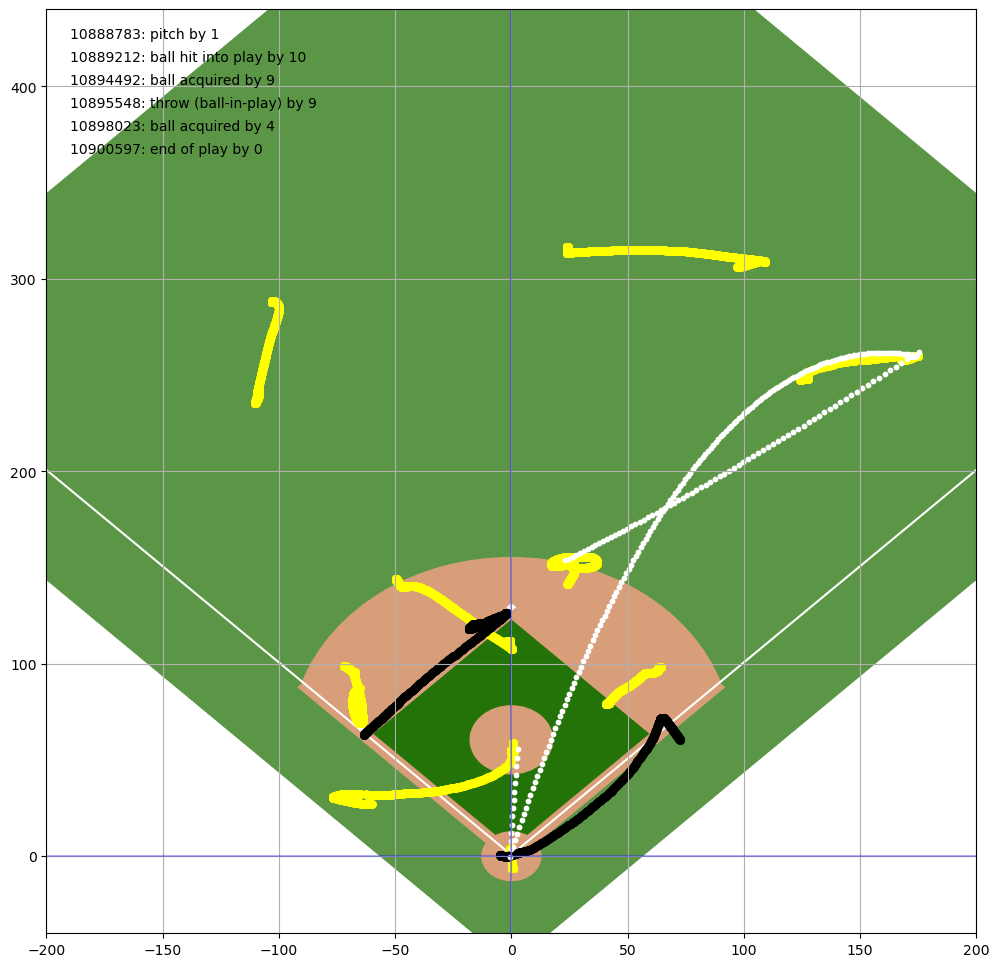

In [5]:
bf_1903_01.clear_plot()

play_id = 325


bf_1903_01.plot_all_components(play_id=play_id)
bf_1903_01.fig

# bf_1903_01.create_gif(play_id=play_id, tag="--check when removing events")

In [ ]:
frames